In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
import theano.tensor.slinalg as sla

In [2]:
dataset=[]
with open("HSTest_Normalized.txt","r") as f:
    data = []
    for line in f:
        if line.strip()=="":
            dataset.append(np.array(data))
            data=[]
        else:
            data.append(float(line.strip()))
    dataset.append(data)
dataset=np.array(dataset)


In [3]:
print(dataset.shape)

(208,)


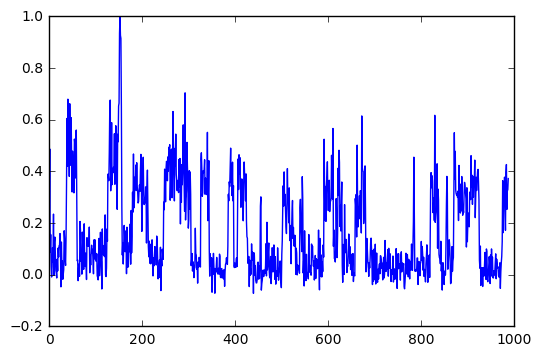

In [4]:
plt.plot(dataset[205])

In [5]:
# Two state model for simplicity.
N_states = 2
N_chain = len(dataset[30])

# Transition probability stochastic
theta = np.ones(N_states) + 1.
alphaA1 = 2.1
betaA1 = 1.1
alphaA2 = 2.1
betaA2 = 1.1
# inv gamma for S
# mean = beta/(alpha-1), var = beta**2/(alpha-1)**2/(alpha-2) = mean**2/(alpha-2)
# I want mean=0.3, var=mean**2
alphaS = 3.0
betaS = 0.2*2

In [6]:
class HMMStatesN(pm.Categorical):
    """
    Hidden Markov Model States
    Parameters
    ----------
    P : tensor
        transition probability
        shape = (N_states,N_states)
        
    PA : tensor
         equilibrium probabilities
         shape = (N_states)
    
    """

    def __init__(self, PA=None, P=None, N_states=2,
                 *args, **kwargs):
        super(pm.Categorical, self).__init__(*args, **kwargs)
        self.P = P
        self.PA = PA
        self.k = N_states
        self.mode = tt.cast(0,dtype='int64')

    def logp(self, x):
        P = self.P
        PA = self.PA
                
        PS = P[x[:-1]]
                
        x_i = x[1:]
        ou_like = pm.Categorical.dist(PS).logp(x_i)
        return pm.Categorical.dist(PA).logp(x[0]) + tt.sum(ou_like)

In [7]:
class HMMGaussianEmissions(pm.Continuous):
    """
    Hidden Markov Model Gaussian Emissions
    Parameters
    ----------
    A : tensor
        prior for Gaussian emission mu
        shape = (2,N_states)
        
    S : tensor
        prior for Gaussian emission width
        shape = (2,N_states)
    
    states : tensor
         equilibrium probabilities
         shape = (N_states)
    
    """

    def __init__(self, A1=None, A2=None, S1=None, S2=None, states=None,
                 *args, **kwargs):
        super(HMMGaussianEmissions, self).__init__(*args, **kwargs)
        self.A1 = A1
        self.S1 = S1
        self.A2 = A2
        self.S2 = S2
        self.states = states
        self.mean = 0.

    def logp(self, x):
        A1 = self.A1
        S1 = self.S1
        A2 = self.A2
        S2 = self.S2
        states = self.states
        
        AT = tt.stack((A1,A2))
        AS = AT[states]
        
        ST = tt.stack((S1,S2))
        SS = ST[states]
        
        ou_like = pm.Normal.dist(mu=AS,sd=SS).logp(x)
        return tt.sum(ou_like)

In [8]:
#theano.config.exception_verbosity = 'high'
from scipy import optimize
with pm.Model() as model:
    # 2 state model
    P = pm.Dirichlet('P', a=np.ones((N_states,N_states)), shape=(N_states,N_states))
    
    A1 = pm.Normal('A1',mu=0, sd=0.3)
    A2 = pm.Normal('A2',mu=1, sd=0.3)
    S1 = pm.InverseGamma('S1',alpha=alphaS, beta=betaS)
    S2 = pm.InverseGamma('S2',alpha=alphaS, beta=betaS)
    
    AA = tt.dmatrix('AA')
        
    AA = tt.eye(N_states) - P + tt.ones(shape=(N_states,N_states))
    
    PA = pm.Deterministic('PA',sla.solve(AA.T,tt.ones(shape=(N_states))))
    
    states = HMMStatesN('states',P=P,PA=PA, shape=N_chain)
    
    emission = HMMGaussianEmissions('emission',
                                    A1=A1,
                                    A2=A1,
                                    S1=S1,
                                    S2=S2,
                                    states=states,
                                    observed = dataset[205])
    
    start = pm.find_MAP(fmin=optimize.fmin_powell)
    step1 = pm.Metropolis(vars=[P, PA, A1, A2, S1, S2, emission])
    step2 = pm.BinaryGibbsMetropolis(vars=[states])
    trace = pm.sample(10000, start=start, step=[step1, step2])

Optimization terminated successfully.
         Current function value: -318.368971
         Iterations: 6
         Function evaluations: 510


100%|██████████| 10000/10000 [3:29:28<00:00,  1.60s/it]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10cbe4b70>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x121cc3710>]], dtype=object)

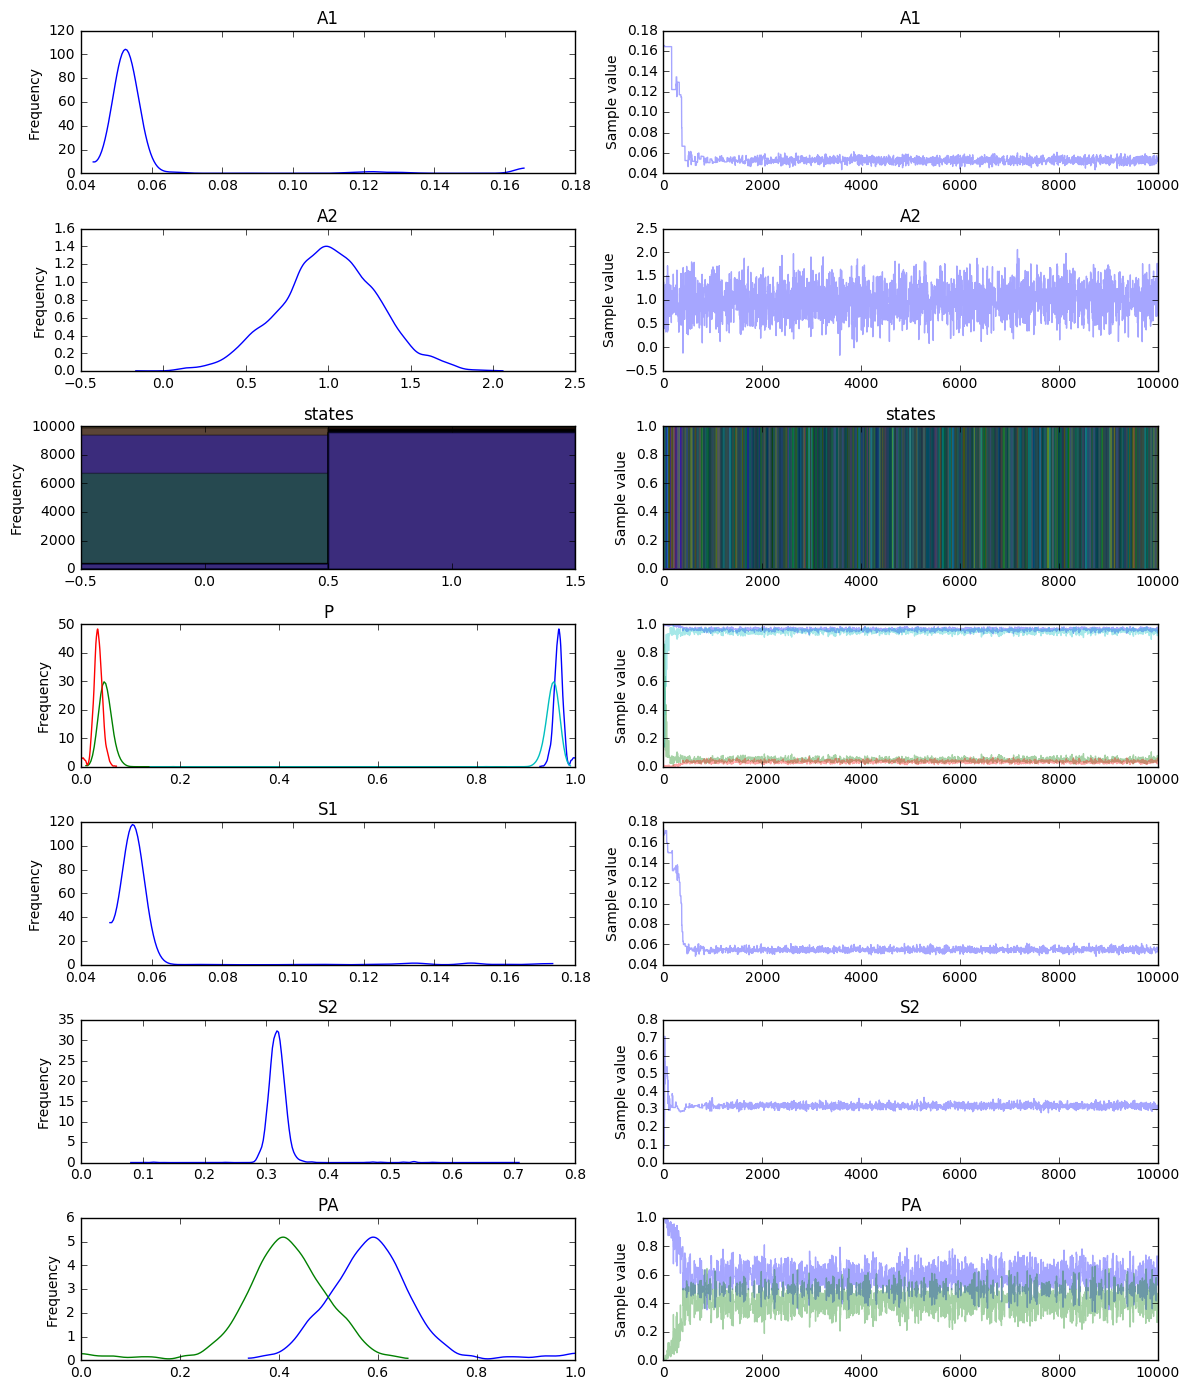

In [9]:
pm.traceplot(trace)

In [10]:
sample_avg=np.average(trace['states'][500:],axis=0)

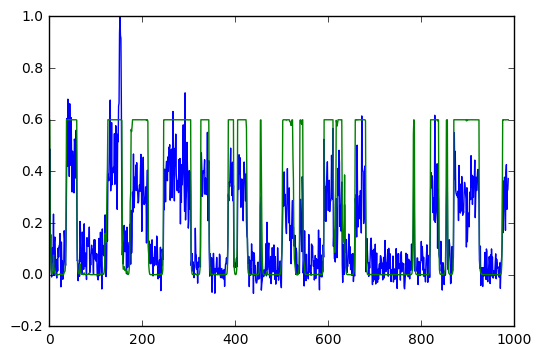

In [11]:
plt.plot(dataset[205])
plt.plot((sample_avg)*0.6)

In [12]:
pm.summary(trace[500:])


A1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.053            0.002            0.000            [0.048, 0.057]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.048          0.051          0.053          0.054          0.058


A2:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.999            0.296            0.006            [0.449, 1.627]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.412          0.817          0.999          1.193          1.594


states:

  Mean             SD               MC Error         95% HPD interval
  ------------------------------